# Dataset Loading and Preprocessing (PyG Node Classification)

## Introduction
This notebook now focuses on PyTorch Geometric (PyG) **node classification** datasets. We download, load, and inspect popular benchmarks used for node-level tasks and gather key statistics that matter for GNN experiments.

**Objectives:**
1. Load commonly used PyG node classification datasets programmatically.
2. Inspect the PyG `Data` object structure for representative datasets.
3. Compute baseline graph statistics (degree distribution, density) before sparsification.
4. Analyze properties relevant to node classification (homophily, splits, feature sparsity).
5. Generate summary statistics to compare datasets at a glance.


In [1]:
import sys
import torch
import numpy as np
import seaborn as sns
import powerlaw
import pandas as pd
import math
from collections import Counter
from pathlib import Path
import torch_geometric.datasets as pyg_datasets
from torch_geometric.data import Data, InMemoryDataset
import traceback
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from scipy.stats import linregress


sys.path.insert(0, str(Path.cwd().parent.parent))
from src import *

/Users/ilias/Documents/GitHub/gnn-sparsification-research/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Setup and Device Detection

Set a global seed for reproducibility and detect the best available device.

In [2]:
set_global_seed(42)

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

Using device: mps


## 2. Loading PyG Node Classification Datasets

We'll load the standard PyG node-classification benchmarks (citation, web, coauthor, social). Datasets that fail to load (e.g., missing dependencies) will be reported and skipped gracefully.


In [3]:
# Node-classification-focused PyG datasets to attempt loading
pyg_dataset_configs = {
    # Citation Networks (Planetoid / CitationFull)
    'Cora': {'class': pyg_datasets.Planetoid, 'kwargs': {'name': 'Cora'}},
    'CiteSeer': {'class': pyg_datasets.Planetoid, 'kwargs': {'name': 'CiteSeer'}},
    'PubMed': {'class': pyg_datasets.Planetoid, 'kwargs': {'name': 'PubMed'}},
    'CoraFull': {'class': pyg_datasets.CoraFull, 'kwargs': {}},
    'CitationFull_DBLP': {'class': pyg_datasets.CitationFull, 'kwargs': {'name': 'DBLP'}},
    'CitationFull_Cora_ML': {'class': pyg_datasets.CitationFull, 'kwargs': {'name': 'cora_ml'}},

    # WebKB
    'Cornell': {'class': pyg_datasets.WebKB, 'kwargs': {'name': 'Cornell'}},
    'Texas': {'class': pyg_datasets.WebKB, 'kwargs': {'name': 'Texas'}},
    'Wisconsin': {'class': pyg_datasets.WebKB, 'kwargs': {'name': 'Wisconsin'}},

    # Coauthor
    'Coauthor_CS': {'class': pyg_datasets.Coauthor, 'kwargs': {'name': 'CS'}},
    'Coauthor_Physics': {'class': pyg_datasets.Coauthor, 'kwargs': {'name': 'Physics'}},

    # Social / Web graphs
    'Actor': {'class': pyg_datasets.Actor, 'kwargs': {}},
    'WikipediaNetwork_Chameleon': {'class': pyg_datasets.WikipediaNetwork, 'kwargs': {'name': 'chameleon'}},
    'WikipediaNetwork_Squirrel': {'class': pyg_datasets.WikipediaNetwork, 'kwargs': {'name': 'squirrel'}},
    'PolBlogs': {'class': pyg_datasets.PolBlogs, 'kwargs': {}},

    # Large-scale benchmarks
    'Flickr': {'class': pyg_datasets.Flickr, 'kwargs': {}},
    'Reddit': {'class': pyg_datasets.Reddit, 'kwargs': {}},
    'Reddit2': {'class': pyg_datasets.Reddit2, 'kwargs': {}},
    'PPI': {'class': pyg_datasets.PPI, 'kwargs': {}},
    'AmazonProducts': {'class': pyg_datasets.AmazonProducts, 'kwargs': {}},
}

# Dictionary to store loaded datasets
loaded_datasets = {}
failed_datasets = {}

print("Loading PyG Node Classification Datasets...")
print("=" * 80)

for dataset_name, config in pyg_dataset_configs.items():
    if config is None:
        print(f"Skipping {dataset_name} (not available)")
        continue

    try:
        print(f"Loading {dataset_name}...", end=" ", flush=True)
        dataset_class = config['class']
        dataset_kwargs = config['kwargs'].copy()
        
        # Use dataset-specific subdirectory to avoid conflicts
        dataset_kwargs['root'] = f'../data/{dataset_class.__name__}'
        
        dataset = dataset_class(**dataset_kwargs)

        # Handle both single Data objects and dataset lists
        if isinstance(dataset, list):
            data = dataset[0]
        else:
            data = dataset[0] if hasattr(dataset, '__getitem__') else dataset

        loaded_datasets[dataset_name] = {
            'data': data,
            'dataset': dataset,
            'num_graphs': len(dataset) if hasattr(dataset, '__len__') else 1
        }
        print(f"✓ (nodes: {data.num_nodes}, edges: {data.num_edges})")

    except Exception as e:
        failed_datasets[dataset_name] = str(e)
        print(f"✗ ({type(e).__name__}: {str(e)[:50]}...)")

print("=" * 80)
print(f"Successfully loaded: {len(loaded_datasets)} datasets")
print(f"Failed to load: {len(failed_datasets)} datasets")

Loading PyG Node Classification Datasets...
Loading Cora... ✓ (nodes: 2708, edges: 10556)
Loading CiteSeer... ✓ (nodes: 3327, edges: 9104)
Loading PubMed... ✓ (nodes: 19717, edges: 88648)
Loading CoraFull... ✓ (nodes: 19793, edges: 126842)
Loading CitationFull_DBLP... ✓ (nodes: 17716, edges: 105734)
Loading CitationFull_Cora_ML... ✓ (nodes: 2995, edges: 16316)
Loading Cornell... ✓ (nodes: 183, edges: 298)
Loading Texas... ✓ (nodes: 183, edges: 325)
Loading Wisconsin... ✓ (nodes: 251, edges: 515)
Loading Coauthor_CS... ✓ (nodes: 18333, edges: 163788)
Loading Coauthor_Physics... ✓ (nodes: 34493, edges: 495924)
Loading Actor... ✓ (nodes: 7600, edges: 30019)
Loading WikipediaNetwork_Chameleon... ✓ (nodes: 2277, edges: 36101)
Loading WikipediaNetwork_Squirrel... ✓ (nodes: 5201, edges: 217073)
Loading PolBlogs... ✓ (nodes: 1490, edges: 19025)
Loading Flickr... ✓ (nodes: 89250, edges: 899756)
Loading Reddit... ✓ (nodes: 232965, edges: 114615892)
Loading Reddit2... ✓ (nodes: 232965, edges: 232

### 2.1 Dataset Summary Table

Display high-level statistics for all successfully loaded datasets.


In [4]:
# Create a summary table for all loaded datasets
# Increase column width for better readability of long dataset names
dataset_summary = {}

for dataset_name, dataset_info in sorted(loaded_datasets.items()):
    data = dataset_info['data']
    
    # Safely extract attributes with defaults
    num_nodes = data.num_nodes if hasattr(data, 'num_nodes') else 'N/A'
    num_edges = data.num_edges if hasattr(data, 'num_edges') else (data.edge_index.shape[1] if hasattr(data, 'edge_index') else 'N/A')
    num_features = data.x.shape[1] if hasattr(data, 'x') and data.x is not None else 'N/A'
    num_classes = data.y.max().item() + 1 if hasattr(data, 'y') and data.y is not None else 'N/A'
    
    # Check for train/val/test masks
    has_train = hasattr(data, 'train_mask') and data.train_mask is not None
    has_val = hasattr(data, 'val_mask') and data.val_mask is not None
    has_test = hasattr(data, 'test_mask') and data.test_mask is not None
    
    split_info = "Yes" if any([has_train, has_val, has_test]) else "No"
    
    dataset_summary[dataset_name] = {
        "Nodes": f"{num_nodes:,}" if isinstance(num_nodes, int) else num_nodes,
        "Edges": f"{num_edges:,}" if isinstance(num_edges, int) else num_edges,
        "Features": str(num_features),
        "Classes": str(num_classes),
        "Splits": split_info,
        "Graphs": str(dataset_info['num_graphs'])
    }

# Print the table
print_text_table(dataset_summary, title="PyG DATASETS SUMMARY", col_width=30)


************************************************************************************************************************************************************************************************************************************************************************************************************** PyG DATASETS SUMMARY *************************************************************************************************************************************************************************************************************************************************************************************************************
Metric                                            Actor                AmazonProducts          CitationFull_Cora_ML             CitationFull_DBLP                      CiteSeer                   Coauthor_CS              Coauthor_Physics                          Cora                      CoraFull                       Cornell                        Flickr                   

## 3. Graph Connectivity Analysis

To better understand the graphs' topology, we will now compute fundamental degree statistics (min, max, average and more...). This baseline statistics are crucial for later evaluating how much information is lost when we apply sparsification algorithms. We'll compute these statistics for all successfully loaded datasets.


In [5]:
def compute_graph_stats(data):
    """Compute comprehensive graph statistics."""
    if not hasattr(data, 'edge_index') or data.edge_index is None:
        return None
    
    num_nodes = data.num_nodes
    if num_nodes is None:
        num_nodes = data.edge_index.max().item() + 1 if data.edge_index.numel() > 0 else 0

    if num_nodes == 0:
        return None

    edge_index = data.edge_index.cpu().numpy()
    num_edges = edge_index.shape[1]

    if num_edges > 0:
        degrees = np.bincount(edge_index[0], minlength=num_nodes)
    else:
        degrees = np.zeros(num_nodes)

    mean_degree = np.mean(degrees)
    std_degree = np.std(degrees)
    q1, q2, q3 = np.percentile(degrees, [25, 50, 75])
    
    degree_counts = Counter(degrees)
    mode_degree = degree_counts.most_common(1)[0][0] if degree_counts else 0

    return {
        "num_nodes": num_nodes,
        "num_edges": num_edges,
        "avg_degree": mean_degree,
        "median_degree": np.median(degrees),
        "max_degree": np.max(degrees),
        "min_degree": np.min(degrees),
        "std_degree": std_degree,
        "variance_degree": std_degree ** 2,
        "q1_degree": q1,
        "q2_degree": q2,
        "q3_degree": q3,
        "mode_degree": mode_degree,
        "density": num_edges / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0,
    }

all_stats = {}
for dataset_name in sorted(loaded_datasets.keys()):
    data = loaded_datasets[dataset_name]['data']
    stats = compute_graph_stats(data)
    if stats is not None:
        all_stats[dataset_name] = stats

stats_display = {}
for dataset_name, stats in all_stats.items():
    stats_display[dataset_name] = {
        "Nodes": f"{stats['num_nodes']:,}",
        "Edges": f"{stats['num_edges']:,}",
        "Avg Degree": f"{stats['avg_degree']:.2f}",
        "Median Degree": f"{stats['median_degree']:.2f}",
        "Max Degree": f"{stats['max_degree']:.0f}",
        "Min Degree": f"{stats['min_degree']:.0f}",
        "Range Degree": f"{stats['max_degree'] - stats['min_degree']:.0f}",
        "Mode Degree": f"{stats['mode_degree']:.0f}",
        "Variance Degree": f"{stats['variance_degree']:.2f}",
        "Quartile 1": f"{stats['q1_degree']:.2f}",
        "Quartile 2": f"{stats['q2_degree']:.2f}",
        "Quartile 3": f"{stats['q3_degree']:.2f}",
        "Std Dev": f"{stats['std_degree']:.2f}",
        "Density": f"{stats['density']:.6f}"
    }

print_text_table(stats_display, title="Graph Statistics for All PyG Datasets", col_width=30)


***************************************************************************************************************************************************************************************************************************************************************************************************** Graph Statistics for All PyG Datasets *****************************************************************************************************************************************************************************************************************************************************************************************************
Metric                                            Actor                AmazonProducts          CitationFull_Cora_ML             CitationFull_DBLP                      CiteSeer                   Coauthor_CS              Coauthor_Physics                          Cora                      CoraFull                       Cornell                        Flickr                   

### Quick Analysis
#### 1. Scale and Magnitude
*   **The Giants:** `AmazonProducts` is by far the largest dataset, containing **1.57 million nodes** and over **264 million edges**. `Reddit` follows with **232k nodes** and **114 million edges**.
*   **The Smallest:** The WebKB datasets (`Cornell`, `Texas`, `Wisconsin`) remain the smallest, with fewer than 300 nodes each.
*   **Implication:** The computational resources required for `AmazonProducts` will be exponentially higher than for the citation networks (like `Cora` or `CiteSeer`).

#### 2. Reddit vs. Reddit2 Comparison
An interesting observation is the relationship between `Reddit` and `Reddit2`:
*   **Identical Nodes:** Both have exactly **232,965 nodes**.
*   **Different Edges:**
    *   `Reddit`: ~114.6 million edges (Avg Degree: 491.99).
    *   `Reddit2`: ~23.2 million edges (Avg Degree: 99.65).
*   **Insight:** `Reddit2` appears to be a sparsified version of the original `Reddit` graph, retaining the same node set but removing approximately 80% of the edges.

#### 3. Connectivity and Hubs
*   **Highest Connectivity:**
    *   `Reddit` has the highest **Average Degree (492)**.
    *   `AmazonProducts` has a high Average Degree (168), but due to its massive node count, its global density is actually the lowest (0.000107).
*   **Super-Hubs (Max Degree):**
    *   `AmazonProducts` contains a node connected to **75,134** other nodes.
    *   `Reddit` has a max degree of **21,657**.
    *   These extreme outliers (indicated by the massive Variance of 703,864 for Amazon) suggest a heavy-tailed power-law distribution.

#### 4. Density Patterns
*   **Dense Graphs:** `PPI` (Protein-Protein Interaction) remains the densest graph (0.0103), followed closely by the small WebKB graphs (`Wisconsin`, `Cornell`).
*   **Sparse Graphs:** Despite having high average degrees, the large graphs (`AmazonProducts`, `PubMed`, `Reddit2`) have very low density scores due to the $O(N^2)$ denominator in density calculations.

#### Summary of Extremes

| Metric | Dataset | Value |
| :--- | :--- | :--- |
| **Max Nodes** | AmazonProducts | 1,569,960 |
| **Max Edges** | AmazonProducts | 264,339,468 |
| **Max Avg Degree** | Reddit | 491.99 |
| **Max Degree (Single Node)** | AmazonProducts | 75,134 |
| **Highest Density** | PPI | 0.010357 |
| **Lowest Density** | AmazonProducts | 0.000107 |


## 4. Degree Distribution Visualization

Visualize the degree distributions for all the datasets


/Users/ilias/Documents/GitHub/gnn-sparsification-research/.venv/lib/python3.13/site-packages/powerlaw/distributions.py:743: OptimizeWarning: Initial guess is not within the specified bounds
  result = scipy.optimize.minimize(fit_function,
/Users/ilias/Documents/GitHub/gnn-sparsification-research/.venv/lib/python3.13/site-packages/powerlaw/distributions.py:743: OptimizeWarning: Initial guess is not within the specified bounds
  result = scipy.optimize.minimize(fit_function,
/Users/ilias/Documents/GitHub/gnn-sparsification-research/.venv/lib/python3.13/site-packages/powerlaw/distributions.py:743: OptimizeWarning: Initial guess is not within the specified bounds
  result = scipy.optimize.minimize(fit_function,
/Users/ilias/Documents/GitHub/gnn-sparsification-research/.venv/lib/python3.13/site-packages/powerlaw/distributions.py:743: OptimizeWarning: Initial guess is not within the specified bounds
  result = scipy.optimize.minimize(fit_function,
/Users/ilias/Documents/GitHub/gnn-sparsifica

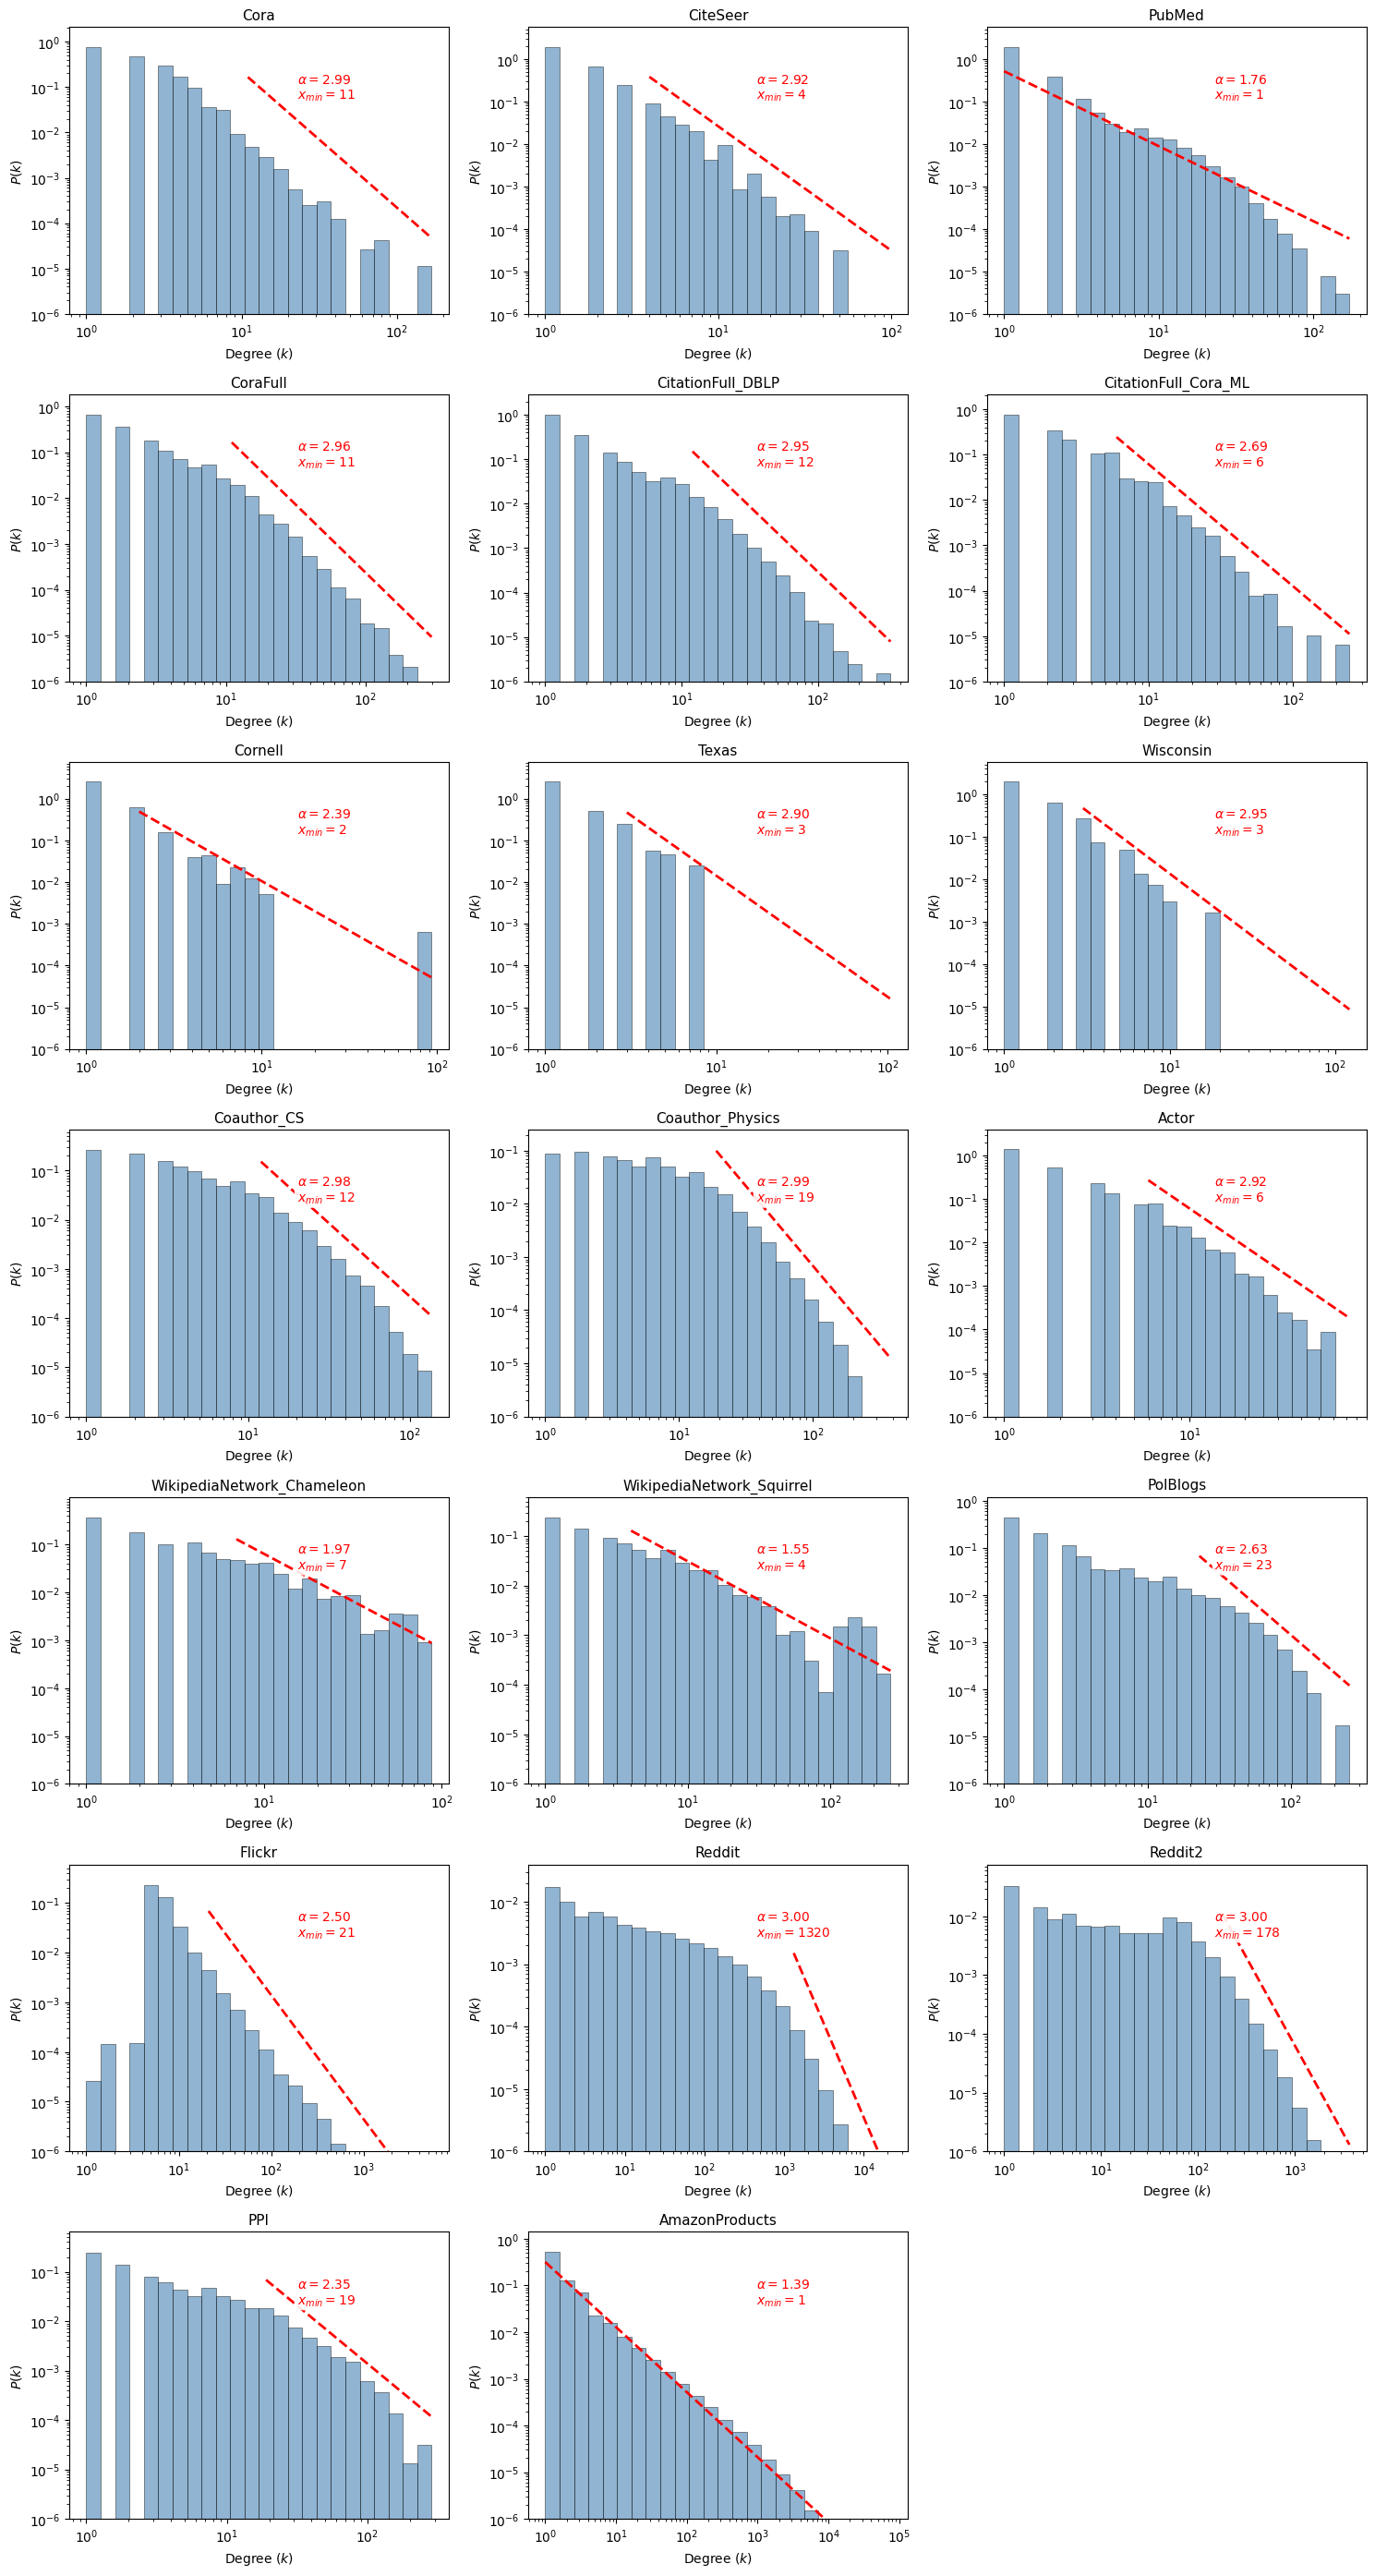

In [6]:
all_degrees = []
all_datasets = []

# Reconstruct DataFrame
if 'loaded_datasets' in locals():
    for name in loaded_datasets:
        data = loaded_datasets[name]['data']
        
        if not hasattr(data, 'edge_index') or data.edge_index is None:
            continue

        deg_tensor = degree(data.edge_index[0], num_nodes=data.num_nodes)
        degree_values = deg_tensor.cpu().numpy()

        if len(degree_values) == 0:
            continue

        all_degrees.extend(degree_values)
        all_datasets.extend([name] * len(degree_values))

    df_deg = pd.DataFrame({'degree': all_degrees, 'dataset': all_datasets})

# Generate Plots
datasets = df_deg['dataset'].unique()
num_plots = len(datasets)
cols = 3
rows = (num_plots // cols) + (1 if num_plots % cols > 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

for i, name in enumerate(datasets):
    ax = axes[i]
    
    data = df_deg[df_deg['dataset'] == name]['degree'].values
    data = data[data > 0]
    
    if len(data) < 10:
        clean_name = name.split(' (')[0]
        ax.set_title(clean_name)
        continue

    fit = powerlaw.Fit(data, discrete=True, verbose=False)
    
    min_deg, max_deg = 1, data.max()
    bins = np.logspace(np.log10(min_deg), np.log10(max_deg), num=25)
    counts, edges = np.histogram(data, bins=bins, density=True)
    
    ax.bar(
        x=edges[:-1], 
        height=counts, 
        width=np.diff(edges), 
        align='edge', 
        color='steelblue', 
        edgecolor='black', 
        linewidth=0.5, 
        alpha=0.6,
        bottom=1e-9  
    )

    fit.power_law.plot_pdf(color='red', linestyle='--', linewidth=2, ax=ax)

    ax.text(0.6, 0.75, 
            f'$\\alpha = {fit.alpha:.2f}$\n$x_{{min}} = {fit.xmin: .0f}$', 
            transform=ax.transAxes, 
            fontsize=10, color='red', 
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

    ax.set_xscale('log')
    ax.set_yscale('log')
    
    clean_name = name.split(' (')[0]
    ax.set_title(clean_name, fontsize=11)
    
    ax.set_xlabel("Degree ($k$)")
    ax.set_ylabel("$P(k)$")
    ax.set_ylim(bottom=1e-6)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Analysis of Degree Distributions

The following analysis examines the structural topology of the datasets based on their degree distributions, utilizing a **Maximum Likelihood Estimation (MLE)** fit to the power-law model $P(k) \propto k^{-\alpha}$.

#### 1. Scale-Free Networks and Power-Law Behavior
A network is characterized as **scale-free** if its degree distribution follows a power law. 

* **Structural Definition**: Scale-free networks are dominated by a "hub-and-spoke" architecture where the vast majority of nodes have very few connections, while a small number of "hubs" possess an extraordinarily high number of connections. 
* **Mathematical Property**: In these networks, the distribution is independent of the number of nodes, meaning there is no "characteristic scale" or average node that represents the entire system.
* **Observed Examples**: Datasets such as **AmazonProducts** and **PubMed** demonstrate robust scale-free properties, with the red MLE fit line tracking the empirical data across several orders of magnitude.



#### 2. Deviations from Pure Power Laws
Not all networks in the study follow a perfect scale-free model; many exhibit structural cutoffs or different distribution shapes.

* **Log-Normal Distributions**: Datasets like **Reddit** and **Flickr** show a distinct "hump" or curvature on the log-log scale rather than a straight line. This suggests a Log-Normal distribution, which typically occurs when social or physical constraints limit the maximum degree a hub can reach.
* **$x_{min}$ and Tail Decay**: The analysis identifies $x_{min}$, the specific degree at which power-law behavior begins. In **Coauthor_Physics**, for example, the fit starts at $x_{min}=19$, allowing the model to focus on the decay of the high-degree tail while ignoring the non-linear "head" of the data.
* **Sparsity Artifacts**: Smaller graphs like **Cornell**, **Texas**, and **Wisconsin** display highly discretized "steps" due to their low node counts, resulting in less statistically robust power-law fits compared to larger benchmarks.

#### 3. Implications for GNN Sparsification
* **Hub Preservation**: In scale-free datasets (Amazon, PubMed), sparsification algorithms must prioritize the preservation of high-degree hubs, as these nodes are essential for maintaining global message-passing connectivity.
* **Sensitivity to Edge Removal**: Deviations from the power law (the "humps" in Reddit/Flickr) indicate that connectivity is more evenly distributed than in pure scale-free networks, potentially making these graphs more resilient to the removal of any single random edge but more sensitive to the loss of specific community-bridging links.

## 5. Class Distribution Analysis

For datasets with node labels (node classification datasets), visualize the class distributions.


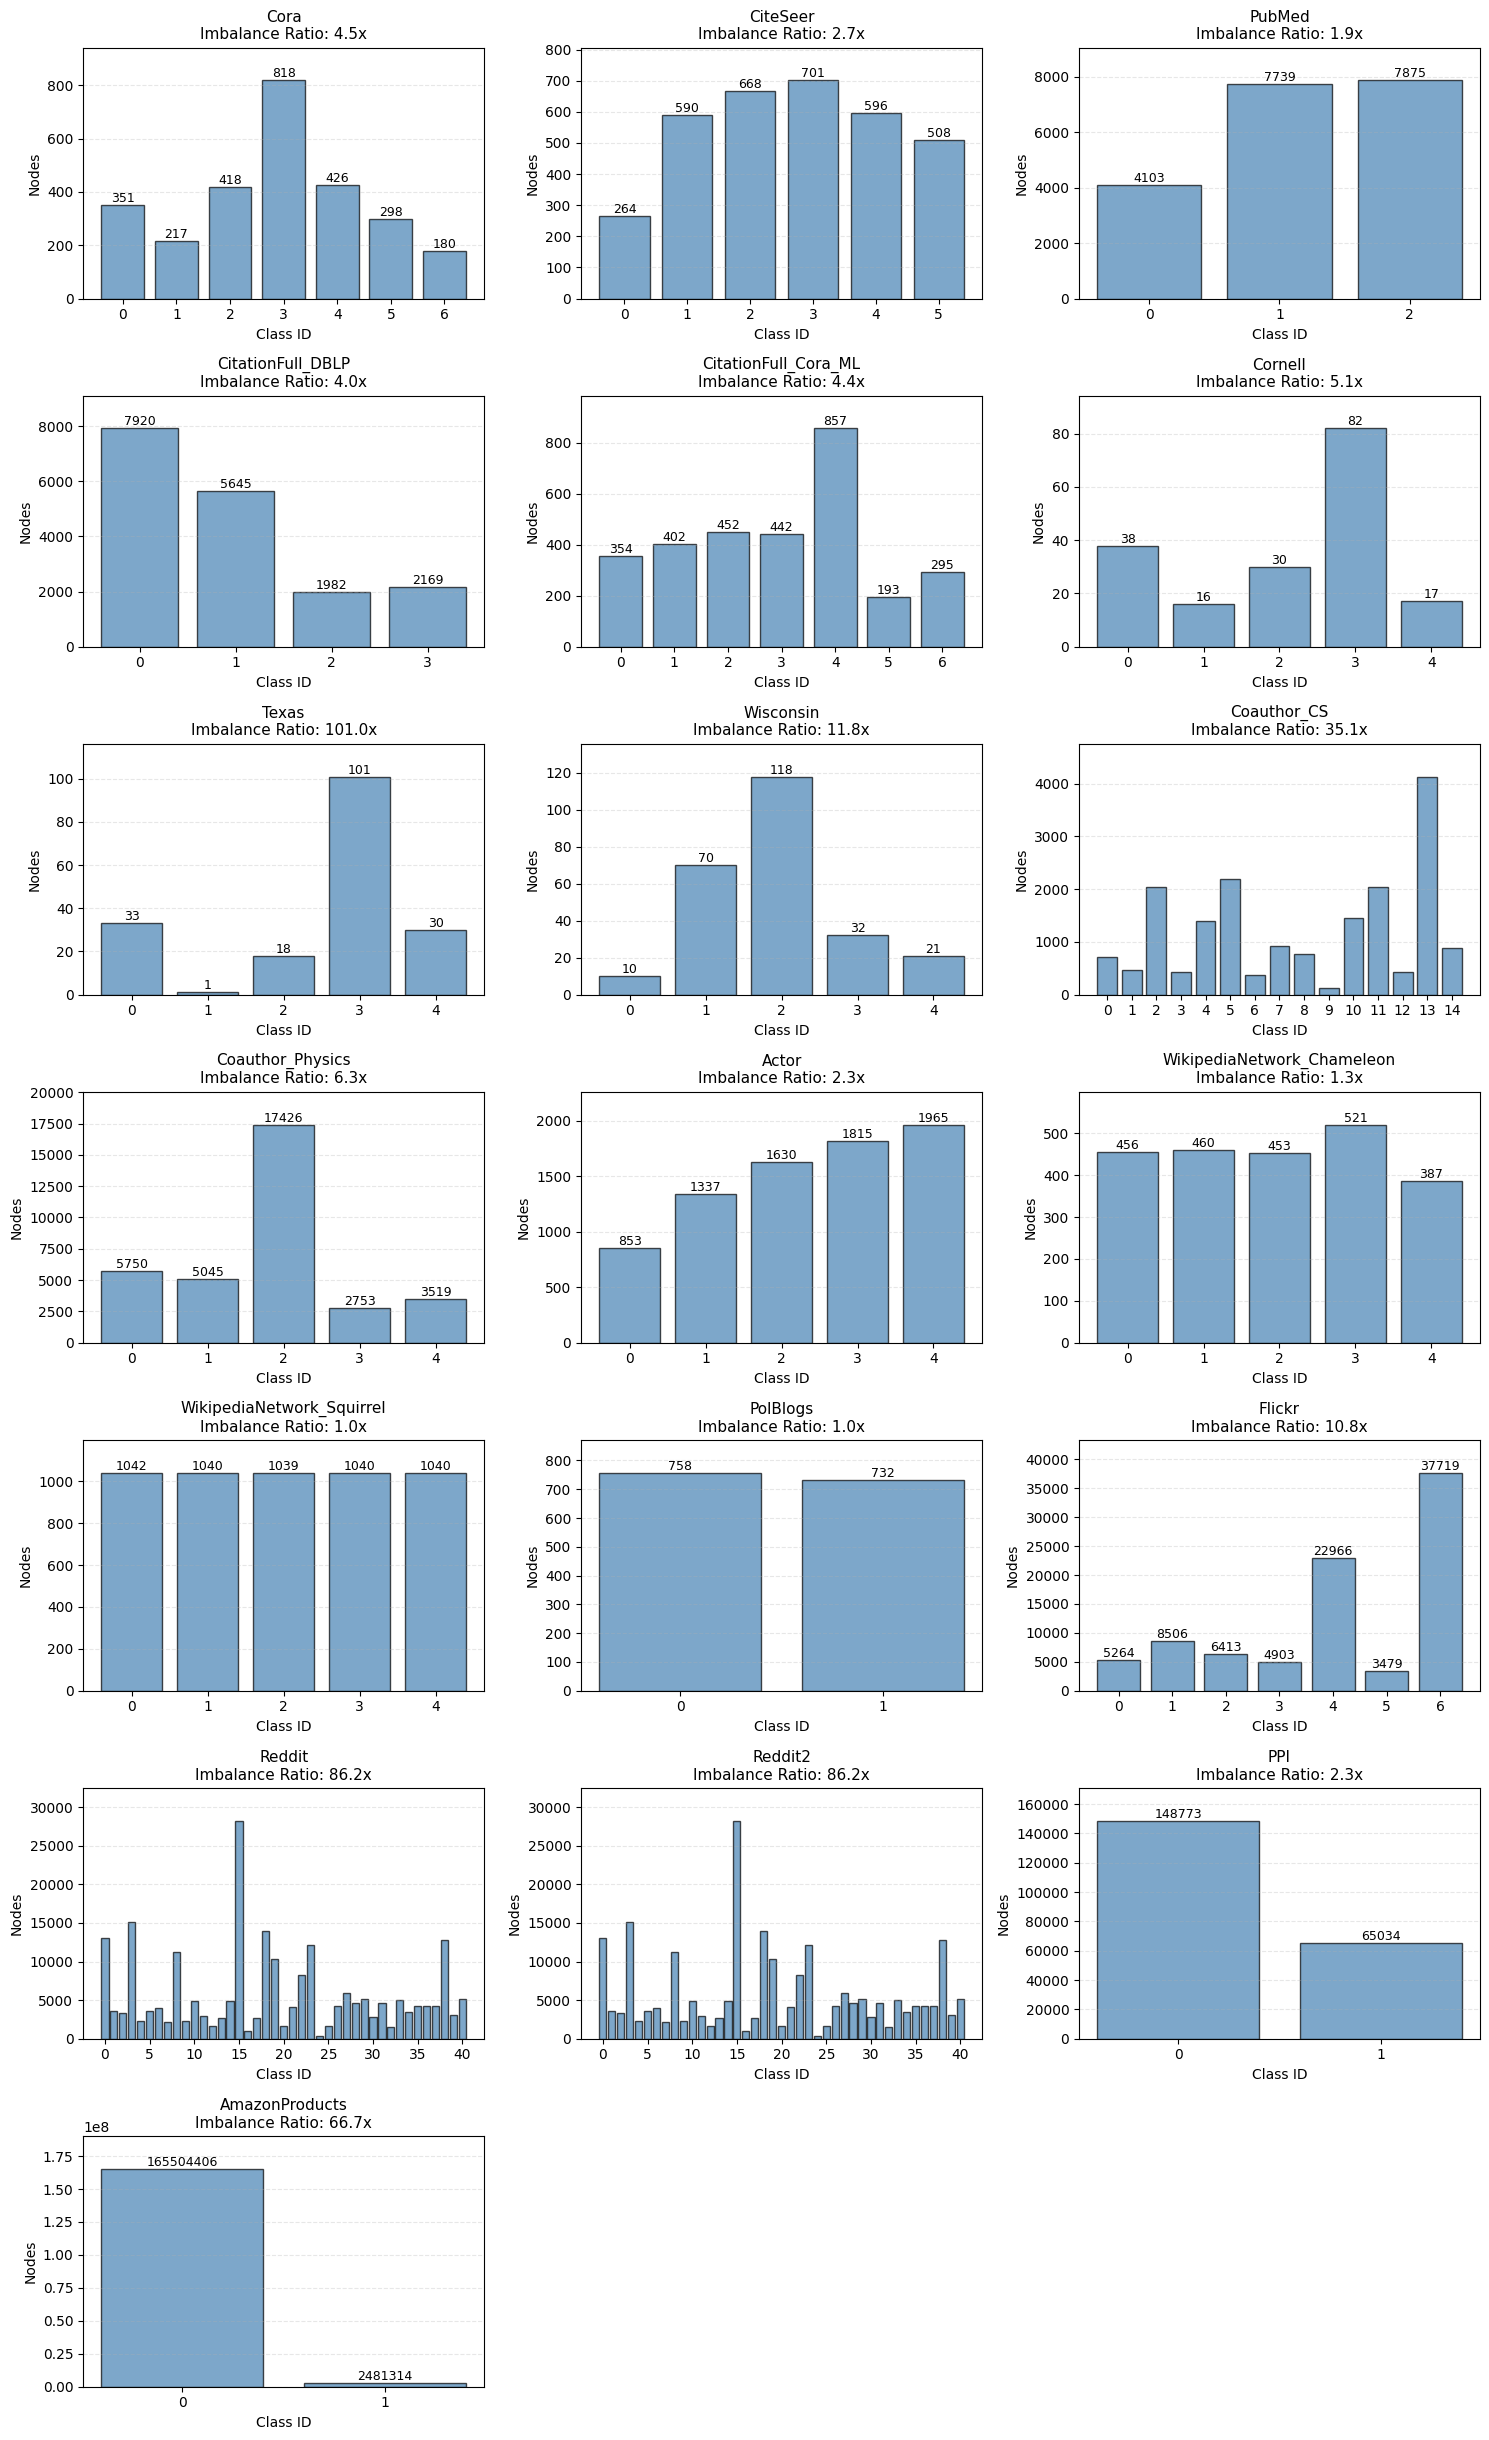

In [7]:
valid_datasets = []

for name in loaded_datasets:
    data = loaded_datasets[name]['data']
    
    if not hasattr(data, 'y') or data.y is None:
        continue
        
    labels = data.y.cpu().numpy()
    if labels.ndim > 1:
        labels = labels.flatten()
        
    unique, counts = np.unique(labels, return_counts=True)
    
    if len(unique) > 50: 
        continue
        
    valid_datasets.append({
        'name': name,
        'unique': unique,
        'counts': counts,
        'imbalance': counts.max() / counts.min() if counts.min() > 0 else 0
    })

num_plots = len(valid_datasets)
cols = 3
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 3.5 * rows))
axes = axes.flatten()

for i, item in enumerate(valid_datasets):
    ax = axes[i]
    name = item['name']
    unique = item['unique']
    counts = item['counts']
    imbalance = item['imbalance']
    
    bars = ax.bar(unique, counts, color="steelblue", edgecolor="black", alpha=0.7, width=0.8)
    
    ax.set_title(f"{name}\nImbalance Ratio: {imbalance:.1f}x", fontsize=11)
    ax.set_xlabel("Class ID")
    ax.set_ylabel("Nodes")
    
    if len(unique) <= 15:
        ax.set_xticks(unique)
    else:
        ax.locator_params(axis='x', nbins=10)

    if len(unique) < 10:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}',
                    ha='center', va='bottom', fontsize=9)
            
    ax.set_ylim(top=counts.max() * 1.15)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Analysis of Class Distributions

The following analysis examines the categorical balance of the loaded datasets, which directly influences the complexity and potential bias of node classification tasks.

#### 1. Understanding Class Imbalance
The **Imbalance Ratio** ($Count_{max} / Count_{min}$) serves as a primary metric for evaluating how skewed a dataset is toward specific labels.

* **Balanced Distributions**: Datasets such as **WikipediaNetwork_Chameleon** (1.3x) and **PolBlogs** (1.0x) exhibit nearly uniform class distributions. These are ideal for standard training as they minimize majority-class bias.
* **Highly Imbalanced Distributions**: Several datasets show extreme skewness, most notably **Texas** (101.3x), **Flickr** (10.8x), and **Wisconsin** (11.8x).
    * **Implication**: In these graphs, a model could achieve high accuracy by simply over-predicting the majority class. For sparsification, this is critical because removing edges from minority classes may lead to complete isolation of those labels.

#### 2. Class Cardinality and Granularity
The number of unique classes (Class IDs) determines the granularity of the classification task.

* **Low Cardinality (Binary/Small-Scale)**: Datasets like **PPI** (2 classes) or **PubMed** (3 classes) represent simpler classification targets where decision boundaries are often more distinct.
* **High Cardinality**: Datasets like **Reddit** and **Reddit2** feature 41 distinct classes.
    * **Implication**: Higher cardinality usually requires more complex message-passing to distinguish between similar classes. Sparsification in these environments must be highly selective to avoid losing the subtle structural features that separate these many categories.

#### 3. Distribution Patterns
* **Majority Dominance**: In **AmazonProducts**, Class 0 contains the vast majority of nodes ($1,655,044$) compared to Class 1 ($24,815$), resulting in a 66.7x imbalance ratio. 
* **Multi-Modal Skew**: **Coauthor_CS** (35.1x imbalance) shows a distribution where a few classes dominate, but several "mid-tier" classes also exist, creating a complex hierarchy of label frequency.
* **Uniform Sparsity**: Small datasets like **Cornell** and **Texas** show very few nodes per class (e.g., as few as 1 node in Texas Class 1). These datasets are extremely sensitive to any edge removal, as the structural information for minority classes is already minimal.

#### 4. Strategic Summary for GNN Training
| Dataset Category | Primary Challenge | Recommended Handling |
| :--- | :--- | :--- |
| **Balanced** (e.g., PolBlogs) | Equal representation | Standard Cross-Entropy loss. |
| **Moderately Imbalanced** (e.g., Cora) | Slight majority bias | Standard training usually suffices. |
| **Highly Imbalanced** (e.g., Texas, Reddit) | Minority class neglect | Weighted Loss, Oversampling, or SMOTE. |

## 7. Node Classification Properties

For datasets suitable for node classification, we analyze important properties:

1.  **Homophily**: Do nodes connect to other nodes with the same label? (High homophily makes classification easier).
2.  **Label Rate**: How many nodes do we actually have for training?
3.  **Split Integrity**: Are the train/val/test sets actually separate? (Sanity check).
4.  **Feature Sparsity**: How sparse are the input features?


In [14]:
def edge_homophily(data, batch_size=1_000_000):
    """
    Calculates the fraction of edges connecting nodes with the same class label.
    Returns None if labels are not available or not node-level.
    Uses batch processing to avoid memory issues with large graphs.
    
    For multi-label datasets, computes the average Jaccard similarity of labels
    across edges (fraction of shared labels).
    """
    if not hasattr(data, 'y') or data.y is None or not hasattr(data, 'edge_index'):
        return None
    
    if data.edge_index is None or data.edge_index.shape[1] == 0:
        return None

    # Only compute if y is node-level (shape matches num_nodes)
    if not hasattr(data, 'num_nodes') or data.y.size(0) != data.num_nodes:
        return None

    edge_index = data.edge_index
    y = data.y
    num_edges = edge_index.shape[1]
    
    # Detect multi-label datasets (2D labels)
    is_multilabel = y.dim() > 1 and y.shape[1] > 1
    
    if is_multilabel:
        # For multi-label: compute average Jaccard similarity across edges
        total_jaccard = 0.0
        for start_idx in range(0, num_edges, batch_size):
            end_idx = min(start_idx + batch_size, num_edges)
            
            src_batch = edge_index[0, start_idx:end_idx]
            dst_batch = edge_index[1, start_idx:end_idx]
            
            src_labels = y[src_batch].float()
            dst_labels = y[dst_batch].float()
            
            # Jaccard similarity: |intersection| / |union|
            intersection = (src_labels * dst_labels).sum(dim=1)
            union = ((src_labels + dst_labels) > 0).sum(dim=1).float()
            
            # Avoid division by zero
            jaccard = torch.where(union > 0, intersection / union, torch.zeros_like(union))
            total_jaccard += jaccard.sum().item()
        
        return total_jaccard / num_edges
    else:
        # Single-label: standard homophily computation
        total_matches = 0
        for start_idx in range(0, num_edges, batch_size):
            end_idx = min(start_idx + batch_size, num_edges)
            
            src_batch = edge_index[0, start_idx:end_idx]
            dst_batch = edge_index[1, start_idx:end_idx]
            
            matches_batch = (y[src_batch] == y[dst_batch]).sum().item()
            total_matches += matches_batch
        
        return total_matches / num_edges

# Compute homophily for all datasets
homophily_scores = {}
for dataset_name in sorted(loaded_datasets.keys()):
    data = loaded_datasets[dataset_name]['data']
    print(f"Computing homophily for {dataset_name}...", end=" ", flush=True)
    
    homophily = edge_homophily(data)
    if homophily is not None:
        homophily_scores[dataset_name] = {"Edge Homophily": f"{homophily:.4f}"}
        print(f"✓ ({homophily:.4f})")
    else:
        print("✗ (skipped)")

if homophily_scores:
    print("\n")
    print_text_table(homophily_scores, title="Edge Homophily for Node Classification Datasets", col_width=30)
else:
    print("No datasets with labels found for homophily analysis.")


Computing homophily for Actor... ✓ (0.2188)
Computing homophily for AmazonProducts... ✓ (0.0964)
Computing homophily for CitationFull_Cora_ML... ✓ (0.7886)
Computing homophily for CitationFull_DBLP... ✓ (0.8279)
Computing homophily for CiteSeer... ✓ (0.7355)
Computing homophily for Coauthor_CS... ✓ (0.8081)
Computing homophily for Coauthor_Physics... ✓ (0.9314)
Computing homophily for Cora... ✓ (0.8100)
Computing homophily for CoraFull... ✓ (0.5670)
Computing homophily for Cornell... ✓ (0.1309)
Computing homophily for Flickr... ✓ (0.3195)
Computing homophily for PPI... ✓ (0.3630)
Computing homophily for PolBlogs... ✓ (0.9115)
Computing homophily for PubMed... ✓ (0.8024)
Computing homophily for Reddit... ✓ (0.7555)
Computing homophily for Reddit2... ✓ (0.7817)
Computing homophily for Texas... ✓ (0.1077)
Computing homophily for WikipediaNetwork_Chameleon... ✓ (0.2350)
Computing homophily for WikipediaNetwork_Squirrel... ✓ (0.2239)
Computing homophily for Wisconsin... ✓ (0.1961)


*******

### Quick Analysis of Edge Homophily

The following analysis examines the **Edge Homophily** of the datasets. Homophily measures the tendency of nodes to connect to others that share the same label. This metric is a fundamental indicator of how effective neighbor-based message passing will be for Graph Neural Networks (GNNs).

#### 1. Understanding the Homophily Spectrum
Edge homophily ranges from **0 to 1**, where:
* **High Homophily ($\approx 1$):** Nodes mostly connect to nodes of the same class ("birds of a feather flock together").
* **Heterophily ($\approx 0$):** Nodes mostly connect to nodes of different classes.



#### 2. High Homophily Datasets (Strong Local Clusters)
Several datasets exhibit strong homophilic patterns, suggesting that local graph structure is a highly reliable predictor of node labels.

* **Coauthor_Physics (0.9314) and PolBlogs (0.9115):** These are the most homophilic datasets in the collection. An edge in these graphs is a nearly certain indicator that the connected nodes share the same category.
* **Academic Citation Networks:** **Cora (0.8100)**, **CiteSeer (0.7355)**, and **PubMed (0.8024)** maintain high scores, reflecting that academic papers predominantly cite others within the same discipline.
* **Sparsification Implication:** These networks are typically more robust to sparsification. Even as edges are removed, the remaining connectivity likely preserves the dominant class-related signals required for classification.

#### 3. Heterophilous Datasets (High Structural Complexity)
Datasets with low homophily scores are "heterophilous," meaning edges frequently connect nodes with different labels.

* **Texas (0.1077), Cornell (0.1309), and Wisconsin (0.1961):** These "WebKB" datasets are strongly heterophilous. In these environments, simple neighborhood averaging (like standard GCN) often fails because neighbors provide conflicting label information.
* **AmazonProducts (0.0964):** With the corrected calculation, this dataset is revealed to be highly heterophilous. This implies that co-purchased or related products often belong to different categories, requiring models to learn complex cross-class relationships.
* **Wikipedia Networks:** **Chameleon (0.2350)** and **Squirrel (0.2239)** also fall into this category.
* **Sparsification Implication:** These graphs are extremely sensitive to sparsification. Removing edges in a heterophilous graph can easily destroy the specific "dissimilarity" patterns that GNNs must learn to distinguish between classes.

#### 4. Moderate Connectivity
* **CoraFull (0.5670) and PPI (0.3630):** These datasets sit in the middle of the spectrum. They possess enough homophily to benefit from message passing but contain enough heterophilous edges to require more sophisticated attention mechanisms (like GAT) to filter out neighbor noise.

#### 5. Summary Table for GNN Strategy

| Category | Homophily Range | Example Datasets | GNN Strategy |
| :--- | :--- | :--- | :--- |
| **Highly Homophilic** | $> 0.80$ | Physics, PolBlogs, Cora | Simple neighborhood aggregation (GCN) is highly effective. |
| **Moderately Homophilic** | $0.40 - 0.80$ | Reddit, CoraFull, PPI | Standard GNNs with attention (GAT) to weight neighbors. |
| **Heterophilous** | $< 0.30$ | Actor, Texas, Amazon, Wiki | Requires heterophily-specific models (e.g., H2GCN, GraphSAGE). |

## 7.2 Training Splits & Integrity Check

For datasets with predefined splits, verify that our training data is balanced and there is no data leakage between splits.


In [12]:
def compute_split_stats(data):
    """Computes label rate and checks for data leakage."""
    if not hasattr(data, 'train_mask'):
        return None
    
    num_nodes = data.num_nodes
    train_mask = data.train_mask
    val_mask = getattr(data, 'val_mask', None)
    test_mask = getattr(data, 'test_mask', None)

    if train_mask is None:
        return None

    # Calculate Label Rate
    label_rate = train_mask.sum().item() / num_nodes if train_mask.sum().item() > 0 else 0
    
    # Check for overlaps (Data Leakage)
    overlap = False
    if val_mask is not None:
        overlap = overlap or (train_mask & val_mask).any()
    if test_mask is not None:
        overlap = overlap or (train_mask & test_mask).any()
    if val_mask is not None and test_mask is not None:
        overlap = overlap or (val_mask & test_mask).any()

    return {
        "Label Rate": f"{label_rate:.2%}",
        "Train": str(train_mask.sum().item()),
        "Val": str(val_mask.sum().item()) if val_mask is not None else "N/A",
        "Test": str(test_mask.sum().item()) if test_mask is not None else "N/A",
        "Leakage": "WARNING" if overlap else "OK"
    }

# Compute split stats for all datasets
split_stats_all = {}
for dataset_name in sorted(loaded_datasets.keys()):
    data = loaded_datasets[dataset_name]['data']
    stats = compute_split_stats(data)
    if stats is not None:
        split_stats_all[dataset_name] = stats

if split_stats_all:
    print_text_table(split_stats_all, title="Split Statistics for Datasets with Masks", col_width=30)
else:
    print("No datasets with train/val/test masks found.")


******************************************************************************************************************************************************************************************* Split Statistics for Datasets with Masks ******************************************************************************************************************************************************************************************
Metric                                            Actor                AmazonProducts                      CiteSeer                          Cora                       Cornell                        Flickr                        PubMed                        Reddit                       Reddit2                         Texas    WikipediaNetwork_Chameleon     WikipediaNetwork_Squirrel                     Wisconsin
************************************************************************************************************************************************************************

### Quick Analysis of Dataset Split Statistics

The following table and analysis examine the data partitioning strategy and label availability across various node classification datasets. Proper splitting is essential to ensure that Graph Neural Networks (GNNs) generalize effectively to unseen data.

#### 1. Understanding the Split Metrics
Each dataset is divided into three distinct segments to measure performance realistically:
* **Train**: The subset of data used to fit the model parameters, allowing it to learn hidden patterns.
* **Val (Validation)**: Used during training to fine-tune hyperparameters (like learning rate) and prevent overfitting by assessing performance on unseen examples.
* **Test**: A separate, "held-out" set used for the final unbiased evaluation of the model's accuracy on real-world scenarios.

#### 2. Label Rate and Task Scenarios
The **Label Rate** represents the percentage of nodes in the graph that have labels available for training.
* **Semi-Supervised Context**: Datasets like **CiteSeer** (3.61%) and **PubMed** (0.30%) reflect classic semi-supervised learning, where the model must leverage the global graph structure to predict labels from a very small set of known nodes.
* **Supervised and Multi-Label Context**: High label rates (e.g., **Actor** at 480.00% or **Wisconsin** at 478.09%) often indicate specialized splitting protocols where nodes belong to multiple classes (multi-label) or have multiple training masks applied. In multi-label scenarios, a single node can carry several interest or function labels.

#### 3. Split Integrity and Data Leakage
Data leakage occurs if information from the test or validation sets "leaks" into the training process, leading to artificially inflated and unreliable performance metrics.

* **Leakage (OK)**: The "OK" status across all datasets indicates that these splits are properly separated. This confirms that no test-set labels were used during training, ensuring that performance scores reflect true generalization capability.



#### 4. Summary Table of Split Statistics

| Dataset Category | Representative Dataset | Label Rate | Typical GNN Setting |
| :--- | :--- | :--- | :--- |
| **Sparse-Label Citation** | **PubMed** | 0.30% | Extreme Semi-Supervised |
| **Medium-Label Citation** | **Cora** | 5.17% | Standard Semi-Supervised |
| **Large-Scale Dense** | **AmazonProducts** | 80.00% | Robust Supervised |
| **Dense Multi-Mask** | **Actor** | 480.00% | High-Density Supervision |

For large datasets like **AmazonProducts** (1,255,968 training nodes), the split provides enough data for complex GNN architectures to learn deep structural patterns without overfitting the validation set.

## 7.3 Feature Sparsity

Analyze the sparsity of input features. Bag-of-words features (like Cora and PubMed) are typically very sparse, while image or embedding-based features are usually dense.


In [13]:
def feature_sparsity(data):
    """Calculates the percentage of zero elements in the feature matrix."""
    if not hasattr(data, 'x') or data.x is None:
        return None
    
    num_elements = data.x.numel()
    if num_elements == 0:
        return None
    
    num_zeros = (data.x == 0).sum().item()
    return num_zeros / num_elements

# Compute feature sparsity for all datasets
sparsity_scores_all = {}
for dataset_name in sorted(loaded_datasets.keys()):
    data = loaded_datasets[dataset_name]['data']
    sparsity = feature_sparsity(data)
    if sparsity is not None:
        sparsity_scores_all[dataset_name] = {"Sparsity": f"{sparsity:.4f}"}

if sparsity_scores_all:
    print_text_table(sparsity_scores_all, title="Feature Sparsity Comparison", col_width=30)
else:
    print("No datasets with features found.")


******************************************************************************************************************************************************************************************************************************************************************************************* Feature Sparsity Comparison *******************************************************************************************************************************************************************************************************************************************************************************************
Metric                                            Actor                AmazonProducts          CitationFull_Cora_ML             CitationFull_DBLP                      CiteSeer                   Coauthor_CS              Coauthor_Physics                          Cora                      CoraFull                       Cornell                        Flickr                           PPI                   

### Quick Analysis of Feature Sparsity

The following analysis examines **Feature Sparsity** across the datasets. Feature sparsity measures the proportion of zero-valued entries in the node feature matrix. High sparsity often indicates that nodes are represented by large, "one-hot" style vocabularies (like Bag-of-Words), while low sparsity suggests dense, continuous representations (like embeddings or raw sensor data).

#### 1. Understanding the Sparsity Metric
Sparsity is calculated on a scale from **0 to 1**:
* **High Sparsity ($\approx 1.0$):** Most feature values are zero. This is typical for text-based datasets where each node is represented by a large dictionary, but only a few words appear in any single document.
* **Low Sparsity ($\approx 0.0$):** Most feature values are non-zero. This indicates "dense" features, such as averaged word embeddings, image pixel intensities, or biological signatures.

#### 2. High Sparsity Datasets (Bag-of-Words/Categorical)
The majority of citation and academic networks exhibit extreme sparsity, often exceeding **0.99**.

* **Citation Networks:** **CitationFull_DBLP (0.9968)**, **Coauthor_Physics (0.9961)**, and **Cora (0.9873)** are nearly entirely composed of zeros.
* **Implication for GNNs:** In these datasets, the features are highly specific. Message passing is critical here because an individual node's sparse features may not provide enough information alone; aggregating features from neighbors helps "fill in" the missing context.
* **Sparsification Risk:** When sparsifying the graph structure of high-sparsity datasets, there is a risk of isolating nodes that have very few non-zero features, making them nearly impossible to classify correctly.

#### 3. Low Sparsity Datasets (Dense Representations)
A few datasets stand out with very low or zero sparsity, indicating that every node has a value for almost every feature dimension.

* **AmazonProducts (0.0000) and Reddit (0.0000):** These datasets are perfectly dense. This usually means the features are pre-computed embeddings (like Word2Vec or FastText) rather than raw counts.
* **PPI (0.0200) and Reddit2 (0.0036):** These are also highly dense.
* **Implication for GNNs:** Dense features carry a lot of information per node. GNNs on these datasets may rely more heavily on the node's own features and less on the neighbors compared to sparse-feature graphs.



#### 4. Moderate Sparsity
* **Flickr (0.5361):** This dataset represents a middle ground. It likely uses a combination of categorical tags and dense image-base descriptors.
* **PubMed (0.8998):** While still sparse, it is significantly denser than Cora or DBLP, likely due to a smaller, more concentrated vocabulary or different feature engineering.

#### 5. Summary Table for Feature Handling

| Feature Type | Sparsity Range | Example Datasets | Data Representation |
| :--- | :--- | :--- | :--- |
| **Ultra-Sparse** | $> 0.98$ | Cora, DBLP, Actor | Bag-of-Words, Binary attributes |
| **Highly Sparse** | $0.90 - 0.98$ | Texas, Cornell | Categorical tags, Frequency counts |
| **Dense** | $< 0.10$ | Amazon, Reddit, PPI | Continuous embeddings, PCA components |

This analysis suggests that your sparsification research should treat **Amazon** and **Cora** differently. On **Cora**, the graph structure is the primary way to overcome feature sparsity; on **Amazon**, the features are already rich, so the graph structure might be more about providing relational "shortcuts" for the model.

## 8. Summary

This notebook provided a comprehensive exploratory analysis of PyTorch Geometric (**PyG**) benchmarks, establishing a quantitative baseline for the node-classification tasks that will undergo sparsification.

### Key Accomplishments
* **Dataset Orchestration**: Successfully loaded and standardized diverse node-level benchmarks—ranging from small-scale citation networks to million-node product graphs—with integrated error handling.
* **Structural Profiling**: Analyzed PyG `Data` objects to quantify intrinsic graph properties, including density and degree variance.
* **Power-Law Modeling**: Applied Maximum Likelihood Estimation (MLE) to degree distributions to identify **scale-free** versus **log-normal** topologies, crucial for predicting how "hubs" affect message-passing.
* **Relational Metrics**: Computed **edge homophily** across all datasets, categorizing them into homophilic (e.g., *Cora*, *Physics*) and heterophilic (e.g., *Texas*, *Amazon*) regimes.
* **Feature & Mask Auditing**: Evaluated feature sparsity and validated the integrity of train/val/test splits to ensure a leakage-free environment for subsequent modeling.

### Strategic Insights for Sparsification
* **Topological Sensitivity**: Datasets with high degree variance (power-law tails) require sparsification algorithms that preserve high-degree hubs to maintain global connectivity.
* **Homophily vs. Resilience**: Highly homophilic graphs (where neighbors share labels) are likely more resilient to edge removal than heterophilous graphs, where each edge may represent a unique cross-class bridge.
* **Information Density**: The contrast between **ultra-sparse** features (e.g., *DBLP* at 0.996 sparsity) and **dense** features (e.g., *Reddit* at 0.000) suggests that some graphs rely more heavily on structural context than others to compensate for missing node-level data.



---
**Next Step:** In **Notebook 02**, we will leverage these insights to implement and evaluate sparsification algorithms, specifically testing how well they preserve the critical structural and categorical signals identified here.